## Section 2: Data Exploration & Text Normalization

Here, we will build a sentence-based English-to-Italian translator. To train the model we will be using the user-contributed data for the flash card app Anki. We will be using the ita.txt file which can be downloaded [here](https://www.manythings.org/anki/) (ita-eng.zip). We then print the first few lines.

In [1]:
import pathlib
import csv

N = 5
with open("ENG_ITA.txt") as myfile:
    head = [next(myfile) for x in range(N)]
print(head)

['Hi.\tCiao!\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #607364 (Cero)\n', 'Hi.\tCiao.\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4522287 (Guybrush88)\n', 'Run!\tCorri!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906347 (Guybrush88)\n', 'Run!\tCorra!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906348 (Guybrush88)\n', 'Run!\tCorrete!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906350 (Guybrush88)\n']


Each line is composed by three tab-separated parts:
1. English word/sentence (items increase in complexity over the length of the file)
2. Italian word/sentence
3. copyright.

Next, we will create a list of English and Italian item pairs and to perform **tokenization**.


### Tokenization.
**Tokenization**  is the first step in any NLP pipeline. It has an important effect on the rest of the pipeline. A tokenizer breaks unstructured data and natural language text into chunks of information that can be considered as discrete elements. The token occurrences in a document can be used directly as a vector representing that document. 

This immediately turns an unstructured string (text document) into a numerical data structure suitable for machine learning. They can also be used directly by a computer to trigger useful actions and responses. Or they might be used in a machine learning pipeline as features that trigger more complex decisions or behavior.

Our model will be trained to predict the next word of the target sentence. Therefore, we will perform *word* tokenization (vs, e.g., *sentence* tokenization).

We will do this in three ways. We will first use a set of custom-defined functions to normalize and tokenize (i.e., using *str.split()*) (method 1). Next, we will use a pre-trained ML model to tokenize the non-normalized text and re-train the model (method 2). Finally, we will combine the two approaches by tokenizing with the pre-trained model the text already passed through the custom normalization pipeline (method 3). 

The pre-trained model we will be using comes from the [NLTK]() library. We will call *word_tokenize()*, which uses a sophisticated algorithm to tokenize text into words, called the **Punkt** tokenizer, which is a pre-trained unsupervised machine learning model that was trained on a large corpus of text. It takes into account various linguistic features such as punctuation, capitalization, and contractions to produce more accurate tokenization results.

First, we will train the model using the custom tokenization and then after using the more sophisticated tokenization. We will compare the performance of the models.


### Normalization.
Before tokenization, we will normalize the text using a set of custom functions to:
- Normalize the input line of text by applying the "NFD" normalization.
- Strip any leading and trailing whitespace from the normalized line and make it lowercase.
- Use regular expressions to find specific patterns in the text and substitute them with other text. The function applies four substitution operations (e.g., to match any non-whitespace or non-word character at the start of the line and add a space before it). These were defined after data inspection.
- Split the line at the tab character, using the split("\t") method, and assign the resulting parts to three variables, eng, ita and rest.
- Wrapping the target (Italian) text with [start] and [end] sentinels. The reason for this will only be clear in Section 11.
- expand English contractions (e.g., *he'll* --> *he will*)
- remove meaningless accents (English)
- substitute meaningful accents (Italian)

In [47]:
import unicodedata
import re


def lineSplit(line):
    """Returns first and second columns of text data (eng and Ita)"""
    p1, p2, p3 = line.split("\t")  
    return p1, p2

  
def strip_accents(text):
    """Removes accents. Used for English text only, since accents are meaningless here."""
    try:
        text = unicode(text, 'utf-8')
    except NameError: # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")
    return str(text)

  
def substitute_accented(string):
    """Recodes accents. Used for Italian text only, since accents are meaningful here.
    We need to remember to re-code the output of the decoder back to original encoding."""
    string = re.sub(r'à', 'aa', string)
    string = re.sub(r'è', 'ee', string)
    string = re.sub(r'ì', 'ii', string)
    string = re.sub(r'ò', 'oo', string)
    string = re.sub(r'ù', 'uu', string)
    string = re.sub(r'á', 'aaa', string)
    string = re.sub(r'é', 'eee', string)
    string = re.sub(r'í', 'iii', string)
    string = re.sub(r'ó', 'ooo', string)
    string = re.sub(r'ú', 'uuu', string)  
    return string
  
  
  
# expand contractions (only applies to English)
contractions_dict = {"ain't": "are not", "aren't": "are not", "can't": "cannot", 
                     "can't've": "cannot have", "‘cause": "because", "could've": "could have", 
                     "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", 
                     "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have", 
                     "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'd've": "he would have", 
                     "he'll": "he will", "he's": "he is","he'll've": "he will have", "how'd": "how did",
                     "how'd'y": "how do you", "how'll": "how will", "I'd": "I would", "I'd've": "I would have",
                     "I'll": "I will", "I'll've": "I will have", "I'm": "I am", "I've": "I have", "isn't": "is not",
                     "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                     "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                     "might've": "might have", "mightn't": "might not",
                     "mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                     "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
                     "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
                     "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                     "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                     "so've": "so have", "that'd": "that would", "that'd've": "that would have",
                     "there'd": "there would", "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
                     "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", 
                     "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                     "we're": "we are", "we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have", "what're": "what are", "what've": "what have",
                     "when've": "when have", "where'd": "where did", "where've": "where have", "who'll": "who will",
                     "who'll've": "who will have", "who've": "who have", "why've": "why have", "will've": "will have",
                     "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                     "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",
                     "you'd": "you would", "you'd've": "you would have", "you'll": "you will",
                     "you'll've": "you will have", "you're": "you are", "you've": "you have"}

contractions_re = re.compile('(%s)'%'|'.join(contractions_dict.keys()))


def expand_contractions(string, contractions_dict=contractions_dict):
    """Expands English contractions."""
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, string)
  
  
def normalize(line):
    """Normalizes text by removing/substituting non-ASCII characters,
    replaces uppercase with lowercase,
    splits into two (Eng, Ita) at the tab character,
    adds the [start] and [end] signals"""
    line = line.strip()
    line = line.replace("’", "'") # both exist, so we replace these before expanding contractions
    
    line = expand_contractions(line, contractions_dict=contractions_dict)
    
    line = re.sub(r"^([^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(\s[^ \w])(?!\s)", r"\1 ", line) # will match anything that's not alphanumeric or underscore
    line = re.sub(r"(?!\s)([^ \w])$", r" \1", line)
    line = re.sub(r"(?!\s)([^ \w]\s)", r" \1", line)
    line = re.sub(r"ñ", "n", line)
    line = re.sub(r"ō", "o", line)
    line = re.sub(r"ê", "e", line)
    line = re.sub(r"ü", "u", line)
    line = re.sub(r"º", "o", line)
    line = re.sub(r"€", "Euro", line)
    line = re.sub(r"°c", "oc", line)
    line = re.sub(r"°", " ", line)
    line = re.sub(r"\xa0", " ", line)
    line = re.sub(r"\u200b", "", line)
    line = re.sub(r"   ", " ", line)
    line = re.sub(r"  ", " ", line)
    
    line = line.lower()
    # we run this before and after lowercasing to un-contract first words in the sentence
    # which are not in the dictionary because of the first capital letter.
    line = expand_contractions(line, contractions_dict=contractions_dict)
    
    eng, ita, rest = line.split("\t")
    
    ita = ita.replace("'", " ")
    ita = substitute_accented(ita)
    #ita = re.sub(r'[^\w]', ' ', ita)
    ita = "[start] " + ita + " [end]"
    
    eng = strip_accents(eng)
    #eng = re.sub(r'[^\w]', ' ', eng)
    
    return eng, ita
  
  
def normalize_method2(line):
    line = line.strip()
    line = line.replace("’", "'")
    eng, ita, rest = line.split("\t")
    ita = "[start] " + ita + " [end]"
    return eng, ita

We now pass the *normalize()* function to our input text and save the pairs of items as a [pickle file](https://docs.python.org/3/library/pickle.html).

In [99]:
import pickle
import os



with open('ENG_ITA.txt', 'r', encoding="utf-8") as fp:  
    text_pairs = [normalize(line) for line in fp]

file_name = "ENG_ITA_pairs.pickle"
if os.path.exists(file_name):
    print(f"file '{file_name}' exists in the current directory: not overwriting.")
else:
    print(f"{file_name} does not exist in the current directory: saving.")    
    with open(file_name, "wb") as fp:
        pickle.dump(text_pairs, fp)
    
    
    
with open('ENG_ITA.txt', 'r', encoding="utf-8") as fp:  
    text_pairs_method2 = [normalize_method2(line) for line in fp]
    
file_name = "ENG_ITA_pairs_method2.pickle"
if os.path.exists(file_name):
    print(f"file '{file_name}' exists in the current directory: not overwriting.")
else:
    print(f"{file_name} does not exist in the current directory: saving.")    
    with open(file_name, "wb") as fp:
        pickle.dump(text_pairs, fp)

file 'ENG_ITA_pairs.pickle' exists in the current directory: not overwriting.
file 'ENG_ITA_pairs_method2.pickle' exists in the current directory: not overwriting.


Let's now check the differences in encoding between the normalized and non-normalized text pairs. As you can see, the non-normalized text contain many non-ASCII characters. Luckily, *word_tokenize()* can deal with them.

In [98]:
eng_lines = [line[0] for line in text_pairs]
for i in range(0,len(eng_lines)):
    this_line = eng_lines[i]
    if not this_line.isascii():
        print(f"English line {i} not ASCII: {this_line}")

ita_lines = [line[1] for line in text_pairs]
for i in range(0,len(ita_lines)):
    this_line = ita_lines[i]
    if not this_line.isascii():
        print(f"Italian line {i} not ASCII: {this_line}")
        
eng_lines = [line[0] for line in text_pairs_method2]
for i in range(0,len(eng_lines)):
    this_line = eng_lines[i]
    if not this_line.isascii():
        print(f"Method 2: English line {i} not ASCII: {this_line}")

ita_lines = [line[1] for line in text_pairs_method2]
for i in range(0,len(ita_lines)):
    this_line = ita_lines[i]
    if not this_line.isascii():
        print(f"Method 2: Italian line {i} not ASCII: {this_line}")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



We then print out a few sentences at random before and after normalization. Beyond, lowercasing and the addition of signals, notice, for instance, how in pair 201979 *I can't* becomes *i cannot* (English), or how in pair 220500, *sarò* becomes *saroo* (Italian) after normalization.

In [90]:
import random

with open('ENG_ITA.txt', 'r', encoding="utf8") as fp:  
    tp = [lineSplit(line) for line in fp]   
    
tp_eng1 = [line[0] for line in tp]
tp_eng2 = [line[0] for line in text_pairs]
tp_eng3 = [line[0] for line in text_pairs_method2]
tp_ita1 = [line[1] for line in tp]
tp_ita2 = [line[1] for line in text_pairs]
tp_ita3 = [line[1] for line in text_pairs_method2]

random.seed(0)
for _ in range(3):
    i = random.choice(text_pairs)
    print(f"Sentence nr. {text_pairs.index(i)}:")
    print(f"ENG original: `{tp_eng1[text_pairs.index(i)]}` ")
    print(f"ENG normalized: `{tp_eng2[text_pairs.index(i)]}` ")
    print(f"ITA original: `{tp_ita1[text_pairs.index(i)]}` ")
    print(f"ITA normalized: `{tp_ita2[text_pairs.index(i)]}` ")
    print("")

Sentence nr. 201979:
ENG original: `I can't pretend to like him.` 
ENG normalized: `i cannot pretend to like him .` 
ITA original: `Non riesco a fingere che mi piaccia.` 
ITA normalized: `[start] non riesco a fingere che mi piaccia . [end]` 

Sentence nr. 220500:
ENG original: `I'll never be as rich as Tom.` 
ENG normalized: `i will never be as rich as tom .` 
ITA original: `Non sarò mai ricco come Tom.` 
ITA normalized: `[start] non saroo mai ricco come tom . [end]` 

Sentence nr. 21225:
ENG original: `Let's eat here.` 
ENG normalized: `let us eat here .` 
ITA original: `Mangiamo qui.` 
ITA normalized: `[start] mangiamo qui . [end]` 



Accents are preserved in the non-normalized text instead:

In [91]:
random.seed(0)
for _ in range(3):
    i = random.choice(text_pairs_method2)
    print(f"Sentence nr. {text_pairs_method2.index(i)}:")
    print(f"ENG normalized method 2: `{tp_eng3[text_pairs_method2.index(i)]}` ")
    print(f"ITA normalized method 2: `{tp_ita3[text_pairs_method2.index(i)]}` ")
    print("")

Sentence nr. 201979:
ENG normalized method 2: `I can't pretend to like him.` 
ITA normalized method 2: `[start] Non riesco a fingere che mi piaccia. [end]` 

Sentence nr. 220500:
ENG normalized method 2: `I'll never be as rich as Tom.` 
ITA normalized method 2: `[start] Non sarò mai ricco come Tom. [end]` 

Sentence nr. 21225:
ENG normalized method 2: `Let's eat here.` 
ITA normalized method 2: `[start] Mangiamo qui. [end]` 



We now perform 'custom' and ML model-based tokenization on the non-normalized ('NLTK_1') and normalized ('NLTK_2') text.
We then print out how many tokens we have and what is the maximum item length.


### Optimal number of tokens.
There is no definitive answer for the preferred number of tokens for training a transformer model, as it can depend on several factors such as the complexity of the task, the size and quality of the dataset, and the available computational resources. However, some general guidelines state that a smaller number of tokens (e.g., tens of thousands) is preferable if the dataset is small or of lower quality, or if the task is relatively simple. Since we have a rather small dataset, we  prefer a smaller (vs larger) number of tokens.

In the end, it is possible that none of this will really matter, after limiting the vocabulary size to less tokens than len(tokens). In fact, we expect this to have limited effect, and we will re-train the model mostly to check this. Next, we will increase vocabulary size by a 20%. We expect this to have, instead, a much larger effect.

In [94]:
from nltk.tokenize import word_tokenize

eng_tokens, ita_tokens = set(), set()
eng_maxlen, ita_maxlen = 0, 0

eng_tokens_method2, ita_tokens_method2 = set(), set()
eng_maxlen_method2, ita_maxlen_method2 = 0, 0

eng_tokens_method3, ita_tokens_method3 = set(), set()
eng_maxlen_method3, ita_maxlen_method3 = 0, 0

for eng, ita in text_pairs: 
    eng_tok, ita_tok = eng.split(), ita.split()
    eng_maxlen = max(eng_maxlen, len(eng_tok)) # compare maxlen with len of new token
    ita_maxlen = max(ita_maxlen, len(ita_tok))
    eng_tokens.update(eng_tok) # adds elements if not previously present
    ita_tokens.update(ita_tok)
    
for eng, ita in text_pairs_method2: 
    eng_tok_method2 = word_tokenize(eng)
    ita_tok_method2 = word_tokenize(ita)
    eng_maxlen_method2 = max(eng_maxlen_method2, len(eng_tok_method2))
    ita_maxlen_method2 = max(ita_maxlen_method2, len(ita_tok_method2))
    eng_tokens_method2.update(eng_tok_method2)
    ita_tokens_method2.update(ita_tok_method2)
    
for eng, ita in text_pairs: 
    eng_tok_method3 = word_tokenize(eng)
    ita_tok_method3 = word_tokenize(ita)
    eng_maxlen_method3 = max(eng_maxlen_method3, len(eng_tok_method3))
    ita_maxlen_method3 = max(ita_maxlen_method3, len(ita_tok_method3))
    eng_tokens_method3.update(eng_tok_method3)
    ita_tokens_method3.update(ita_tok_method3)

print(f"Total pairs: {len(text_pairs)}")
print("")
print("                         | custom  |  NLTK_1 | NLTK_2 ")
print("-----------------------------------------------------")
print(f"Total English tokens:    |  {len(eng_tokens)}  |  {len(eng_tokens_method2)}  |  {len(eng_tokens_method3)}")
print(f"Total Italian tokens:    |  {len(ita_tokens)-2}  |  {len(ita_tokens_method2)-2}  |  {len(ita_tokens_method3)-2}") # -2 for [start] [end]
print(f"Max English item length: |   {eng_maxlen}   |   {eng_maxlen_method2}   |   {eng_maxlen_method3}")
print(f"Max Italian item length: |   {ita_maxlen-2}   |   {ita_maxlen_method2-2}   |   {ita_maxlen_method3-2}") # -2 for [start] [end]

Total pairs: 358373

                         | custom | NLTK_1 | NLTK_2 
-----------------------------------------------------
Total English tokens:    |  14524  |  15633  |  14061
Total Italian tokens:    |  27713  |  33149  |  27493
Max English item length: |   111   |   111   |   111
Max Italian item length: |   103   |   105   |   107


The combined normalization + NLTK tokenization seems to have provided the 'best' (less tokens) result. Nevertheless, we are left with quite large numbers of tokens. This is normal since we did not perform stemming or lemmatization.

Let's now visualize some of the most uncommon tokens. This is useful to diagnose how effective our text normalization was.
There are some entries in English, such as *du* or *meatballs* which will confuse the model (e.g., overfit). The same goes for Italian (e.g., *licenzi* or *videoleso*). We will keep this in mind for later stages.
Specifically, when performing *vectorization* (Section 3), we will limit the maximum vocabulary size of the vectorizer, which means that only the most frequent tokens will be considered and encoded. This may be useful to skip the words of little value or with spelling mistakes. We also fix the output length of the vectorizer to 20, since the large majority of sentences have this max len (check figure below; remember log-scaling of y-axis). Thus, output of vectorizer can have no more than 20 tokens.

In [24]:
import random
import collections

random.seed(0)
counter = collections.Counter(eng_tokens)
most_common = counter.most_common()
sorted_eng_list = sorted(most_common, key=lambda x: x[1])

random.seed(0)
counter = collections.Counter(ita_tokens)
most_common = counter.most_common()
sorted_ita_list = sorted(most_common, key=lambda x: x[1])

print("Least common English tokens (N=30):")
print(sorted_eng_list[0:30])
print("")
print("Least common Italian tokens (N=30):")
print(sorted_ita_list[0:30])

least common English tokens (N=30):
[('adore', 1), ('killed', 1), ('duly', 1), ('frozen', 1), ('temporarily', 1), ('barcelona', 1), ('reckless', 1), ('panther', 1), ('meatballs', 1), ('regard', 1), ('punctured', 1), ('unlike', 1), ('beardless', 1), ('serious', 1), ('sales', 1), ('dentist', 1), ('elegant', 1), ('europeans', 1), ('mistrial', 1), ('discrete', 1), ('discarded', 1), ('greener', 1), ('seize', 1), ('android', 1), ('bids', 1), ('indiscreet', 1), ('pharmacist', 1), ('weighed', 1), ('opposition', 1), ('du', 1)]

least common Italian tokens (N=30):
[('esitante', 1), ('divampoo', 1), ('licenzi', 1), ('versatili', 1), ('carpe', 1), ('abitassi', 1), ('misericordioso', 1), ('discrete', 1), ('accetta', 1), ('divennero', 1), ('trafficone', 1), ('budapest', 1), ('insostenibile', 1), ('desideriamo', 1), ('videoleso', 1), ('distratto', 1), ('ferme', 1), ('aerei', 1), ('servizio', 1), ('allegro', 1), ('iniziata', 1), ('comincio', 1), ('jeep', 1), ('legato', 1), ('ulteriori', 1), ('rifate',

Let's now plot a few statistics about this dataset: let's see how long the items (words, sentences, paragraphs) are.

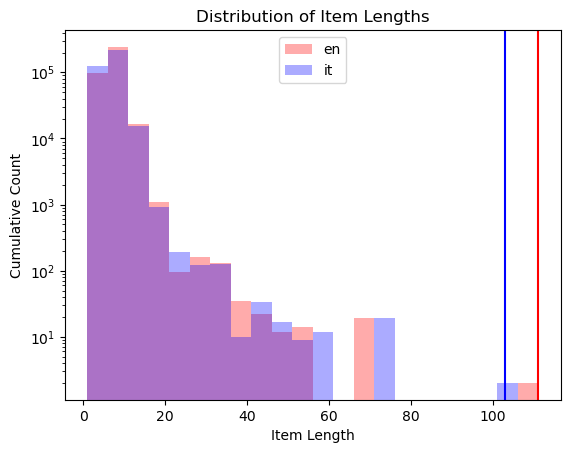

<Figure size 640x480 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt

# histogram of sentence length in tokens
en_lengths = [len(eng.split()) for eng, ita in text_pairs]
it_lengths = [len(ita.split())-2 for eng, ita in text_pairs] # -2 for [start] [end]

binwidth = 5

plt.hist(en_lengths, 
         bins=range(1, eng_maxlen + binwidth, binwidth),
         label="en", color="red", alpha=0.33)
plt.hist(it_lengths,
         bins=range(1, eng_maxlen + binwidth, binwidth),
         label="it", color="blue", alpha=0.33)
plt.yscale("log")     # sentence length fits Benford"s law
plt.ylim(plt.ylim())  # make y-axis consistent for both plots
plt.plot([max(en_lengths), max(en_lengths)], plt.ylim(), color="red")
plt.plot([max(it_lengths), max(it_lengths)], plt.ylim(), color="blue")
plt.xlabel("Item Length")
plt.ylabel("Cumulative Count")
plt.legend()
plt.title("Distribution of Item Lengths")
plt.show()

plt.savefig("section02_figure01_itemLengthDistribution.jpg")

The distribution of token count over item length follows a linear relation in semi-log space in accordance to [Benford's law](https://en.wikipedia.org/wiki/Benford%27s_law). 

We have now normalized our sentences. In the next section we will be performing vectorization.

In [110]:
import os
import pickle

file_name = "NLTK_vocab.pickle"
if os.path.exists(file_name):
    print(f"file '{file_name}' exists in the current directory: not overwriting.")
else:
    print(f"{file_name} does not exist in the current directory: saving.")    
    with open(file_name, "wb") as fp:
        vocab = {
            "vocab_size_eng": len(eng_tokens_method3),
            "vocab_size_ita": len(ita_tokens_method3),
            "vocab_eng": eng_tokens_method3,
            "vocab_ita": ita_tokens_method3
        }
        pickle.dump(vocab, fp)

NLTK_vocab.pickle does not exist in the current directory: saving.
